In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import argparse
import numpy as np
import numpy.typing as npt
import pandas as pd
import yaml

from pathlib import Path
from tqdm import tqdm
from tensorflow import data
from tensorflow.keras.models import load_model

from utils import IsValidFile, IsReadableDir, CreateFolder, predict_single_image
from generator import RegionETGenerator

import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use('CMS')

from typing import List

import json

import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model



In [2]:
def loss(y_true: npt.NDArray, y_pred: npt.NDArray) -> npt.NDArray:
    return np.mean((y_true - y_pred) ** 2, axis=(1, 2, 3))

def quantize(arr: npt.NDArray, precision: tuple = (16, 8)) -> npt.NDArray:
    word, int_ = precision
    decimal = word - int_
    step = 1 / 2**decimal
    max_ = 2**int_ - step
    arrq = step * np.round(arr / step)
    arrc = np.clip(arrq, 0, max_)
    return arrc


def get_deposits(datasets):
    generator = RegionETGenerator()
    deposits, labels = [], []
    for dataset in datasets:
        name = dataset["name"]
        X = generator.get_data(dataset["path"])
        print(f"{name} samples: {X.shape[0]}")
        deposits.append(X)
        labels.append(name)
    return deposits, labels

In [3]:
INTERACTIVE = True
OUT_DIR = 'plots/deep-dive'

def save_fig(name: str):
    plt.savefig(
        f"{OUT_DIR}/{name}.png", bbox_inches="tight"
    )
    if INTERACTIVE:
        plt.show()
    plt.close()

In [ ]:
# setup data loaders & load models
config = yaml.safe_load(open('misc/config-macbook-deep-dive.yml'))

datasets = [i["path"] for i in config["background"] if i["use"]]
datasets = [path for paths in datasets for path in paths]

gen = RegionETGenerator()
(X_train, X_val, X_test), (npv_train, npv_val, npv_test) = gen.get_data_split(datasets, get_npv=True)

# outlier_train = gen.get_data(config["exposure"]["training"])
# outlier_val = gen.get_data(config["exposure"]["validation"])

idx_train, idx_val, idx_test = (npv_train>10), (npv_val>10), (npv_test>10)
X_train, X_val, X_test = X_train[idx_train], X_val[idx_val], X_test[idx_test]

npv_train, npv_val, npv_test = npv_train[idx_train], npv_val[idx_val], npv_test[idx_test]

In [26]:
def scatter_hist(x, ys, ls):
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    
    # no labels
    ax_histx.tick_params(axis="x", labelleft=False, labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False, labelbottom=False)
    ax_histy.tick_params(axis="x", labelleft=False, labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False, labelbottom=False)

    ax.set_xlabel("nPV")
    # ax.set_ylabel("MSE")
    ax.set_ylabel("Anomaly Score")

    # the scatter plot:
    corrs = [np.corrcoef(x, y)[0, 1] for y in ys]

    colors = [("tab:blue", "darkblue"), ("tab:orange", "brown"), ("tab:green", "darkgreen"), ("tab:grey", "black")]

    ax_histx.hist(x, bins=range(80), density=True, alpha=0.3)
    for i, y in enumerate(ys):
        ax.scatter(x, y, alpha=0.1, color=colors[i][0])
        ax_histy.hist(y, bins=range(150), orientation='horizontal', density=True, alpha=0.3, color=colors[i][0])

    means = [[] for _ in ys]
    for n in range(10, 80):
        idx = (x==n)
        for i, y in enumerate(ys):
            s = y[idx]
            means[i].append(np.mean(s))

    for i, l in enumerate(ls):
        ax.plot(range(10, 80), means[i], color=colors[i][1], label=f"{l} (corr={round(corrs[i], 2)})")

    ax.legend(loc="upper right")
    ax.set_xlim((0, 80))
    ax.set_ylim((0, 120))

    save_fig("scatter-npv-anomaly-score")

956/956 [==============================] - 1s 1ms/step


/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


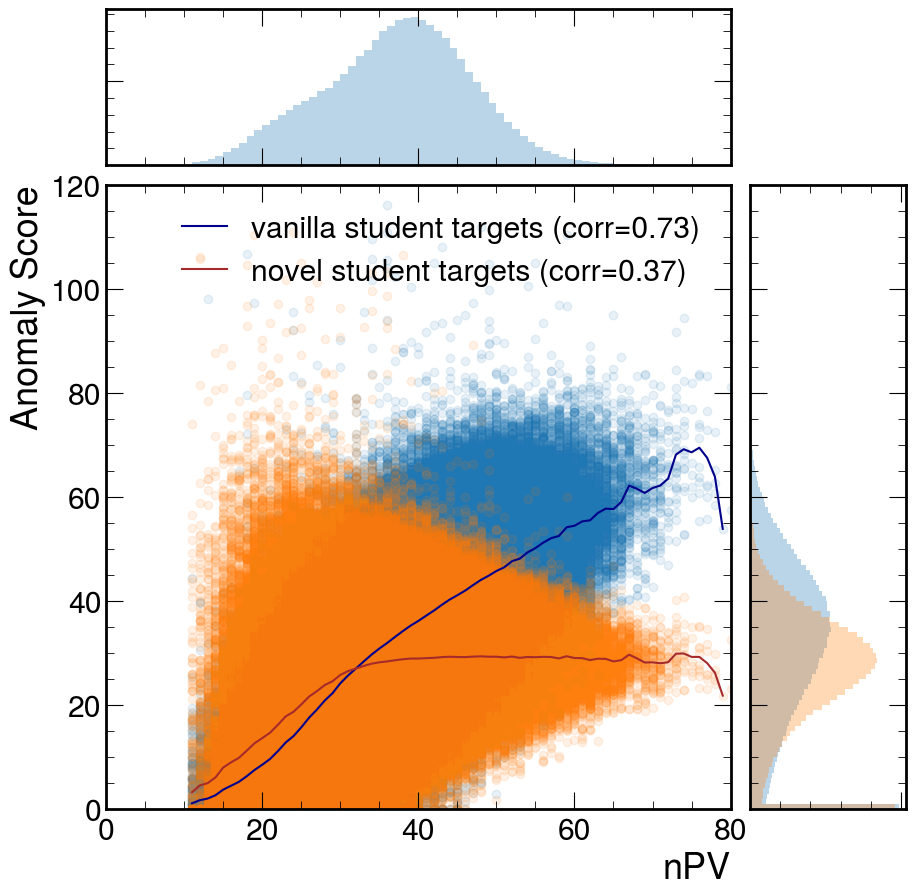

In [29]:
cicada_v2 = load_model("models/from-eos/cicada-v2")
teacher = load_model("models/from-eos/teacher")

teacher_predictions = teacher.predict(X_test, batch_size=512)
mse = loss(X_test, teacher_predictions)
teacher_scores = quantize(np.log(mse)*32)
cicada_v2_scores = cicada_v2.predict(X_test.reshape(-1, 252, 1), batch_size=512).flatten()

# teacher_train_mse = loss(X_train, teacher.predict(X_train, batch_size=512))
# targets_vanilla = quantize(np.log(teacher_train_mse)*32)
# targets_scaled = quantize(np.log(teacher_train_mse)*32*32 / npv_train)

# teacher_val_mse = loss(X_val, teacher.predict(X_val, batch_size=512))
# targets_vanilla_val = quantize(np.log(teacher_val_mse)*32)
# targets_scaled_val = quantize(np.log(teacher_val_mse)*32*32 / npv_val)

scatter_hist(npv_train,
             [targets_vanilla, targets_scaled],
             ["vanilla student targets",
              "novel student targets"])

# scatter_hist(npv_train,
#              [teacher_train_mse],
#              ["Teacher MSE"])

In [52]:
from models import CicadaV2, CicadaV1
student_fresh = CicadaV2((252,)).get_model()
student_fresh.compile(optimizer=Adam(learning_rate=0.001), loss="mae")

# studentv1_fresh = CicadaV1((252,)).get_model()
# studentv1_fresh.compile(optimizer=Adam(learning_rate=0.001), loss="mae")

student_re = load_model("models/from-eos/cicada-v2")

mc_fresh = ModelCheckpoint(f"models/deep-dive/student-fresh", save_best_only=True)
log_fresh = CSVLogger(f"models/deep-dive/student-fresh.log", append=True)
# mc_freshv1 = ModelCheckpoint(f"models/deep-dive/student-fresh", save_best_only=True)
# log_freshv1 = CSVLogger(f"models/deep-dive/student-fresh.log", append=True)
mc_re = ModelCheckpoint(f"models/deep-dive/student-re", save_best_only=True)
log_re = CSVLogger(f"models/deep-dive/student-re.log", append=True)


sample_weights = np.exp((npv_train - npv_train.min()) / npv_train.std())
# Normalize to keep loss values in a reasonable range
sample_weights = sample_weights / sample_weights.mean()


student_fresh.fit(
    X_train.reshape((-1, 252, 1)),
    targets_scaled,
    validation_data=(X_val.reshape((-1, 252, 1)), targets_scaled_val),
    sample_weight=sample_weights,
    batch_size=512,
    epochs=20,
    callbacks=[mc_fresh, log_fresh],
    verbose=True,
)

# studentv1_fresh.fit(
#     X_train.reshape((-1, 252, 1)),
#     targets_scaled,
#     validation_data=(X_val.reshape((-1, 252, 1)), targets_scaled_val),
#     batch_size=512,
#     epochs=20,
#     callbacks=[mc_fresh, log_fresh],
#     verbose=True,
# )

student_re.fit(
    X_train.reshape((-1, 252, 1)),
    targets_scaled,
    validation_data=(X_val.reshape((-1, 252, 1)), targets_scaled_val),
    sample_weight=sample_weights,
    batch_size=512,
    epochs=20,
    callbacks=[mc_re, log_re],
    verbose=True,
)

Epoch 1/20
1186/1195 [============================>.] - ETA: 0s - loss: 15.6772INFO:tensorflow:Assets written to: models/deep-dive/student-fresh/assets


INFO:tensorflow:Assets written to: models/deep-dive/student-fresh/assets


1195/1195 [==============================] - 5s 4ms/step - loss: 15.6195 - val_loss: 11.6590
Epoch 2/20
  42/1195 [>.............................] - ETA: 4s - loss: 6.7495

/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


1182/1195 [============================>.] - ETA: 0s - loss: 5.8176INFO:tensorflow:Assets written to: models/deep-dive/student-fresh/assets


INFO:tensorflow:Assets written to: models/deep-dive/student-fresh/assets


1195/1195 [==============================] - 4s 3ms/step - loss: 5.8143 - val_loss: 5.5731
Epoch 3/20
  64/1195 [>.............................] - ETA: 2s - loss: 5.2074

/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


1179/1195 [============================>.] - ETA: 0s - loss: 5.0555INFO:tensorflow:Assets written to: models/deep-dive/student-fresh/assets


INFO:tensorflow:Assets written to: models/deep-dive/student-fresh/assets


1195/1195 [==============================] - 3s 3ms/step - loss: 5.0533 - val_loss: 5.2479
Epoch 4/20
  64/1195 [>.............................] - ETA: 2s - loss: 4.8582

/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


1195/1195 [==============================] - 3s 3ms/step - loss: 4.9388 - val_loss: 6.0248
Epoch 5/20
1195/1195 [==============================] - 3s 3ms/step - loss: 4.8185 - val_loss: 5.5644
Epoch 6/20
1195/1195 [==============================] - 3s 3ms/step - loss: 4.7510 - val_loss: 5.6561
Epoch 7/20
1195/1195 [==============================] - 3s 2ms/step - loss: 4.7209 - val_loss: 5.5505
Epoch 8/20
1195/1195 [==============================] - 3s 2ms/step - loss: 4.7044 - val_loss: 5.5955
Epoch 9/20
1195/1195 [==============================] - 3s 3ms/step - loss: 4.6930 - val_loss: 5.6317
Epoch 10/20
1195/1195 [==============================] - 3s 2ms/step - loss: 4.7014 - val_loss: 5.3983
Epoch 11/20
1195/1195 [==============================] - 3s 2ms/step - loss: 4.6880 - val_loss: 5.5483
Epoch 12/20
1195/1195 [==============================] - 3s 3ms/step - loss: 4.6810 - val_loss: 5.3620
Epoch 13/20
1195/1195 [==============================] - 3s 2ms/step - loss: 4.6719 - val_

INFO:tensorflow:Assets written to: models/deep-dive/student-re/assets


1195/1195 [==============================] - 4s 3ms/step - loss: 7.7890 - val_loss: 5.2891
Epoch 2/20
1195/1195 [==============================] - 3s 3ms/step - loss: 5.4563 - val_loss: 6.9824
Epoch 3/20
1195/1195 [==============================] - 3s 2ms/step - loss: 5.2438 - val_loss: 5.7272
Epoch 4/20
1195/1195 [==============================] - 3s 2ms/step - loss: 5.0693 - val_loss: 5.6178
Epoch 5/20
1195/1195 [==============================] - 3s 2ms/step - loss: 4.9590 - val_loss: 5.5763
Epoch 6/20
1195/1195 [==============================] - 3s 3ms/step - loss: 4.8848 - val_loss: 5.5488
Epoch 7/20
1195/1195 [==============================] - 3s 3ms/step - loss: 4.8658 - val_loss: 5.6537
Epoch 8/20
1195/1195 [==============================] - 3s 3ms/step - loss: 4.8537 - val_loss: 5.7661
Epoch 9/20
1195/1195 [==============================] - 3s 3ms/step - loss: 4.8511 - val_loss: 5.6525
Epoch 10/20
1195/1195 [==============================] - 3s 3ms/step - loss: 4.8380 - val_los

956/956 [==============================] - 1s 837us/step


/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/linogerlach/Projects/Princeton/cicada/venv39/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


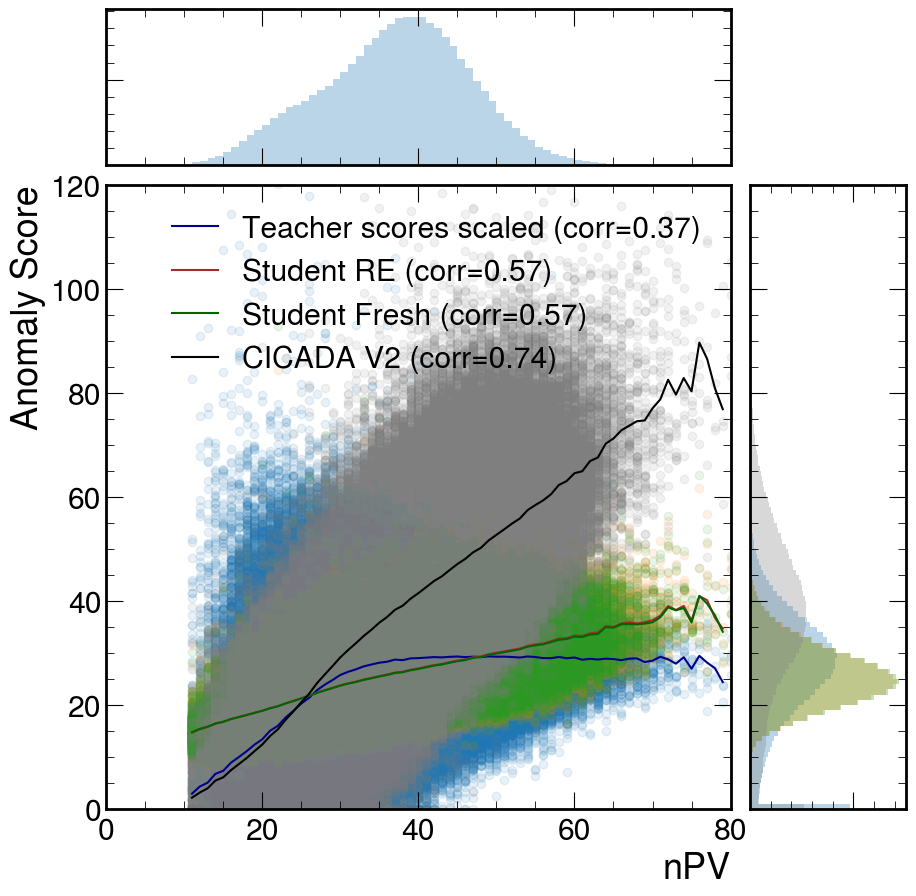

In [53]:
student_re_scores = student_re.predict(X_test.reshape((-1, 252, 1)), batch_size=512).flatten()
student_fresh_scores = student_fresh.predict(X_test.reshape((-1, 252, 1)), batch_size=512).flatten()
# studentv1_fresh_scores = studentv1_fresh.predict(X_test.reshape((-1, 252, 1)), batch_size=512).flatten()



# scatter_hist(npv_test,
#              [cicada_v2_scores, teacher_scores, student_re_scores],
#              ["Teacher scores",
#               "Cicada V2 scores",
#               "Student RE"])

# teacher_predictions = teacher.predict(X_test, batch_size=512)
# mse = loss(X_test, teacher_predictions)
# teacher_scores_scaled = quantize(np.log(mse)*32*32 / npv_test)
cicada_v2_scores = cicada_v2.predict(X_test.reshape(-1, 252, 1), batch_size=512).flatten()

# scatter_hist(npv_test,
#              [teacher_scores_scaled, student_re_scores, student_fresh_scores, studentv1_fresh_scores],
#              ["Teacher scores scaled",
#               "Student RE",
#               "Student Fresh", "StudentV1 Fresh"])

scatter_hist(npv_test,
             [teacher_scores_scaled, student_re_scores, student_fresh_scores, cicada_v2_scores],
             ["Teacher scores scaled",
              "Student RE",
              "Student Fresh", "CICADA V2"])

